# Homework 6

## References

+ Lectures 21-23 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

If on Google Colab, install the following packages:

In [1]:
!pip install gpytorch

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.

    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

def sample_functions(mean_func, kernel_func, num_samples=10, num_test=100, nugget=1e-3):
    """Sample functions from a Gaussian process.

    Arguments:
        mean_func -- the mean function. It must be a callable that takes a tensor
            of shape (num_test, dim) and returns a tensor of shape (num_test, 1).
        kernel_func -- the covariance function. It must be a callable that takes
            a tensor of shape (num_test, dim) and returns a tensor of shape
            (num_test, num_test).
        num_samples -- the number of samples to take. Defaults to 10.
        num_test -- the number of test points. Defaults to 100.
        nugget -- a small number required for stability. Defaults to 1e-5.
    """
    X = torch.linspace(0, 1, num_test)[:, None]
    m = mean_func(X)
    C = k.forward(X, X) + nugget * torch.eye(X.shape[0])
    L = torch.linalg.cholesky(C)
    fig, ax = plt.subplots()
    ax.plot(X, m.detach(), label='mean')
    for i in range(num_samples):
        z = torch.randn(X.shape[0], 1)
        f = m[:, None] + L @ z
        ax.plot(X.flatten(), f.detach().flatten(), color=sns.color_palette()[1], linewidth=0.5,
                label='sample' if i == 0 else None
            )
    plt.legend(loc='best', frameon=False)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_ylim(-5, 5)
    sns.despine(trim=True);


import gpytorch

class ExactGP(gpytorch.models.ExactGP):
    def __init__(self,
                 train_x,
                 train_y,
                 likelihood=gpytorch.likelihoods.GaussianLikelihood(),
                mean_module=gpytorch.means.ConstantMean(),
                covar_module=gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        ):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def plot_1d_regression(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10,
    xlabel='$x$',
    ylabel='$y$'
):
    """Plot the posterior predictive.

    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.

    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    xlabel      --  The x-axis label.
    ylabel      --  The y-axis label.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance
    y_star = model.likelihood(f_star)
    yv_star = y_star.variance

    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )

    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(model.train_inputs[0].flatten().detach(),
            model.train_targets.detach(),
            'k.',
            markersize=1,
            markeredgewidth=2,
            label='Observations'
    )

    ax.plot(
        x_star,
        m_star.detach(),
        lw=2,
        label='Posterior mean',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label='Epistemic uncertainty',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.detach().flatten(),
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label='Aleatory uncertainty'
    )
    ax.fill_between(
        x_star.detach().flatten(),
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None
    )


    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )

    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([10])
        )
        ax.plot(
            x_star.numpy(),
            f_post_samples.T.detach().numpy(),
            color="red",
            lw=0.5
        )
        # This is just to add the legend entry
        ax.plot(
            [],
            [],
            color="red",
            lw=0.5,
            label="Posterior samples"
        )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True)

    return dict(m_star=m_star, v_star=v_star, ax=ax)


def train(model, train_x, train_y, n_iter=10, lr=0.1):
    """Train the model.

    Arguments
    model   --  The model to train.
    train_x --  The training inputs.
    train_y --  The training labels.
    n_iter  --  The number of iterations.
    """
    model.train()
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')
    likelihood = model.likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print(loss)
        return loss
    for i in range(n_iter):
        loss = optimizer.step(closure)
        if (i + 1) % 1 == 0:
            print(f'Iter {i + 1:3d}/{n_iter} - Loss: {loss.item():.3f}')
    model.eval()


## Student details

+ **First Name:** Rohan
+ **Last Name:** Dekate
+ **Email:** dekate@purdue.edu

## Problem 1 - Defining priors on function spaces

In this problem, we will explore further how Gaussian processes can be used to define probability measures over function spaces.
To this end, assume that there is a 1D function, call if $f(x)$, which we do not know.
For simplicity, assume that $x$ takes values in $[0,1]$.
We will employ Gaussian process regression to encode our state of knowledge about $f(x)$ and sample some possibilities.
For each of the cases below:
+ Assume that $f\sim \operatorname{GP}(m, k)$ and pick a mean ($m(x)$) and a covariance function $f(x)$ that match the provided information.
+ Write code that samples a few times (up to five) the values of $f(x)$ at 100 equidistant points between 0 and 1.

### Part A - Super smooth function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ has as many derivatives as you want and they are all continuous
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximatly of size $\Delta x=0.1$.
+ You think that $f(x)$ is between -4 and 4.

**Answer:**

**I am doing this for you so that you have a concrete example of what is requested.**

The mean function should be:

$$
m(x) = 0.
$$

The covariance function should be a squared exponential:

$$
k(x,x') = s^2\exp\left\{-\frac{(x-x')^2}{2\ell^2}\right\},
$$

with variance:

$$
s^2 = k(x,x) = \mathbb{V}[f(x)] = 4,
$$

and lengthscale $\ell = 0.1$.
We chose the variance to be 4.0 so that with (about) 95% probability, the values of $f(x)$ are between -4 and 4.

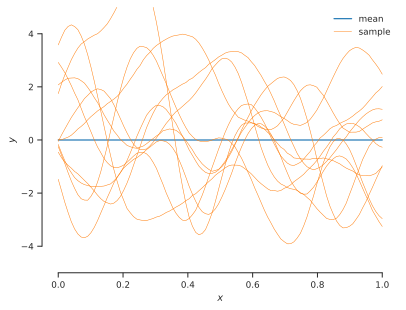

In [3]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel

# Define the covariance function
k = ScaleKernel(RBFKernel())
k.outputscale = 4.0
k.base_kernel.lengthscale = 0.1

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

In [4]:
def sampling(k, num_test=100, nugget = 1e-4, num_samples = 5):
  from gpytorch.means import ConstantMean, LinearMean

  # To ensure reproducibility of the experiments
  torch.manual_seed(123)

  # Number of test points
  # num_test = num_test

  # Pick a mean function
  mean_func = ConstantMean()

  # Pick a bunch of points over which you want to sample the GP
  X = torch.linspace(0, 1, num_test)[:, None]

  # Evaluate the mean function at X
  m = mean_func(X)

  # Compute the covariance function at these points
  # nugget = 1e-4 # This is a small number required for stability
  C = k.forward(X, X) + nugget * torch.eye(X.shape[0])

  # Compute the Cholesky of the covariance
  # Notice that we need to do this only once
  L = torch.linalg.cholesky(C)

  # Number of samples to take
  # num_samples = 5

  # Take samples from the GP and plot them:
  fig, ax = plt.subplots()
  # Plot the mean function
  ax.plot(X, m.detach())
  for i in range(num_samples):
      z = torch.randn(X.shape[0], 1)
      f = m[:, None] + L @ z
      ax.plot(X, f.detach(), color=sns.color_palette()[1], linewidth=1)
  ax.set_xlabel('$x$')
  ax.set_ylabel('$y$')
  ax.set_ylim(-5, 5)
  sns.despine(trim=True);

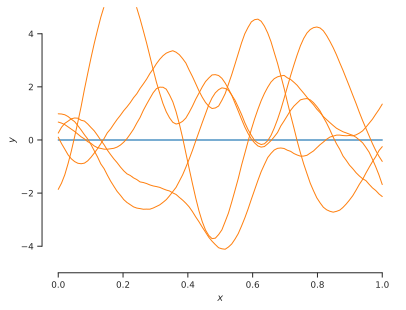

In [5]:
sampling(k=k, num_test=100, nugget = 1e-4, num_samples = 5)

### Part B - Super smooth function with known ultra-small length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ has as many derivatives as you want and they are all continuous
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximatly of size $\Delta x=0.05$.
+ You think that $f(x)$ is between -3 and 3.

**Answer:**

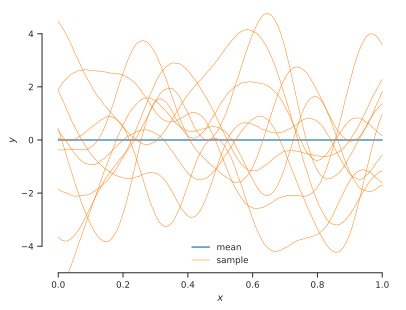

In [6]:
# Your code here
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel

# Define the covariance function
kb = ScaleKernel(RBFKernel()) # Continuous
kb.outputscale = 3 # For variance
kb.base_kernel.lengthscale = 0.05 # For wiggles

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0 # 0 mean since no specific trend

# Sample functions
sample_functions(mean, kb, nugget=1e-4)

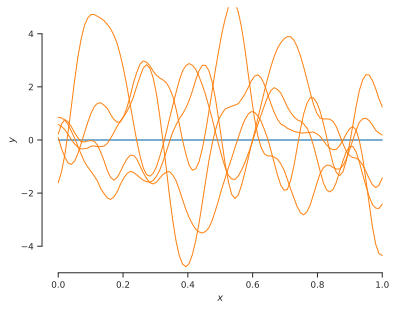

In [7]:
sampling(k=kb, num_test=100, nugget = 1e-4, num_samples = 5)

### Part C - Continuous function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is continuous, nowhere differentiable.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.1$.
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.MaternKernel`` with $\nu=1/2$.

**Answer:**

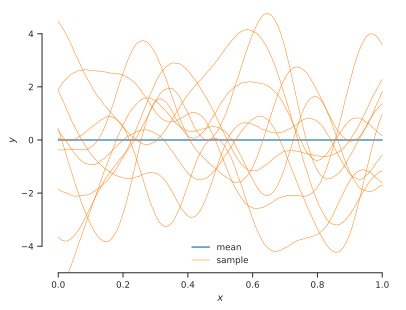

In [8]:
# Your code here
from gpytorch.kernels import MaternKernel

# Define the covariance function
kc = ScaleKernel(MaternKernel(nu=0.5)) # Nowhere differentiable
kc.outputscale = 5 # Variance
kc.base_kernel.lengthscale = 0.1 # For wiggles

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, kc, nugget=1e-4)

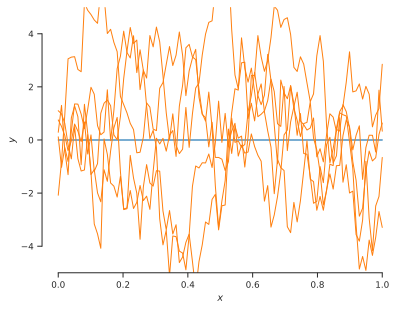

In [9]:
sampling(k=kc, num_test=100, nugget = 1e-4, num_samples = 5)

### Part D - Smooth periodic function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is smooth.
+ You know that $f(x)$ is periodic with period 0.1.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.5$ of the period.
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.PeriodicKernel``.

**Answer:**

PeriodicKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_period_length_constraint): Positive()
)


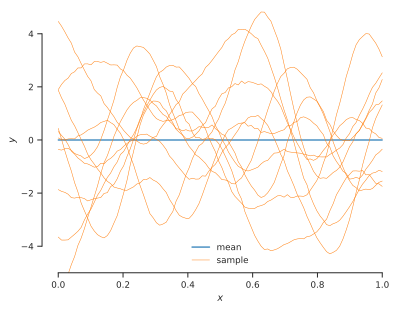

In [10]:
# Your code here
from gpytorch.kernels import PeriodicKernel
mean_func = gpytorch.means.ConstantMean()
kd = ScaleKernel(
        PeriodicKernel() # Smooth & Periodic
    )
print(kd.base_kernel)
kd.base_kernel.period_length = 0.1 # Period
kd.base_kernel.lengthscale = 0.5 # Wiggles
kd.outputscale = 5 # Variance
sample_functions(mean_func, kd, nugget=1e-3)

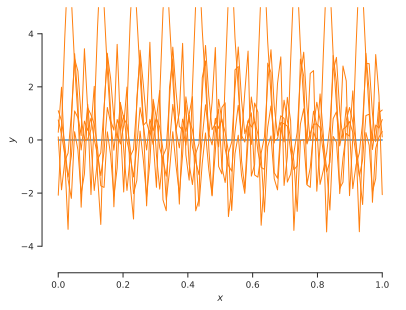

In [11]:
sampling(k=kd, num_test=100, nugget = 1e-3, num_samples = 5)

### Part E - Smooth periodic function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is smooth.
+ You know that $f(x)$ is periodic with period 0.1.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.1$ of the period (**the only thing that is different compared to D**).
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.PeriodicKernel``.


**Answer:**

PeriodicKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_period_length_constraint): Positive()
)


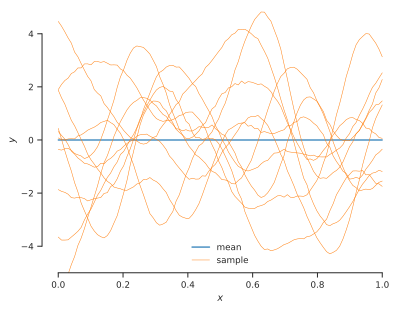

In [12]:
# Your code here
from gpytorch.kernels import PeriodicKernel
mean_func = gpytorch.means.ConstantMean()
ke = ScaleKernel(
        PeriodicKernel() # Smooth and Periodic
    )
print(ke.base_kernel)
ke.base_kernel.period_length = 0.1 # Period
ke.base_kernel.lengthscale = 0.1 # Wiggles
ke.outputscale = 5 # Variance
sample_functions(mean_func, ke, nugget=1e-3)

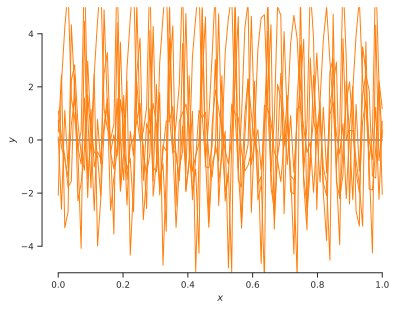

In [13]:
sampling(k=ke, num_test=100, nugget = 1e-3, num_samples = 5)

### Part F - The sum of two functions

Assume that you hold the following beliefs
+ You know that $f(x) = f_1(x) + f_2(x)$, where:
    - $f_1(x)$ is smooth with variance 2 and length scale 0.5
    - $f_2(x)$ is continuous, nowhere differentiable with variance 0.1 and length scale 0.1

Hint: Use must create a new covariance function that is the sum of two other covariances.

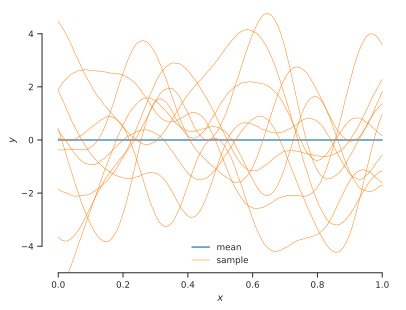

In [14]:
# Your code here
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel

# Define the covariance function
k1 = ScaleKernel(RBFKernel()) # f1(x)
k1.outputscale = 2
k1.base_kernel.lengthscale = 0.5

k2 = ScaleKernel(MaternKernel(nu=0.5)) # f2(x)
k2.outputscale = 0.1
k2.base_kernel.lengthscale = 0.1

kf = k1+k2 # Adding two functions

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, kf, nugget=1e-4)

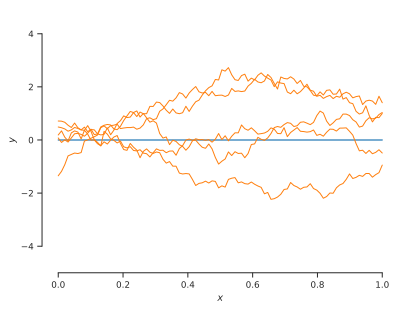

In [15]:
sampling(k=kf, num_test=100, nugget = 1e-4, num_samples = 5)

### Part G - The product of two functions

Assume that you hold the following beliefs
+ You know that $f(x) = f_1(x)f_2(x)$, where:
    - $f_1(x)$ is smooth, periodic (period = 0.1), length scale 0.1 (relative to the period), and variance 2.
    - $f_2(x)$ is smooth with length scale 0.5 and variance 1.

Hint: Use must create a new covariance function that is the product of two other covariances.

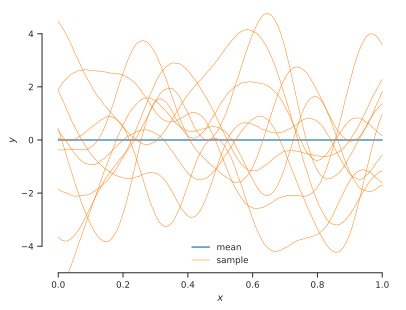

In [16]:
# Your code here
from gpytorch.kernels import PeriodicKernel
mean_func = gpytorch.means.ConstantMean()
k1 = ScaleKernel(
        PeriodicKernel()
    )
# print(k1.base_kernel)
k1.base_kernel.period_length = 0.1 # f1(x)
k1.base_kernel.lengthscale = 0.1
k1.outputscale = 2

# Define the covariance function
k2 = ScaleKernel(RBFKernel()) # f2(x)
k2.outputscale = 1
k2.base_kernel.lengthscale = 0.5

kg = k1*k2 # Product of two functions

sample_functions(mean_func, kg, nugget=1e-4)

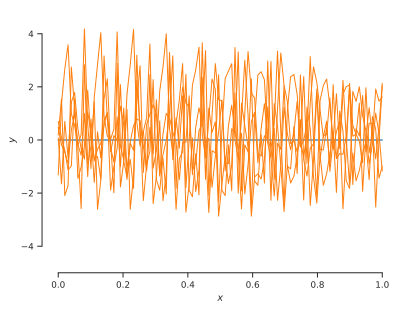

In [17]:
sampling(k=kg, num_test=100, nugget = 1e-4, num_samples = 5)

$\pagebreak$

## Problem 2

The National Oceanic and Atmospheric Administration (NOAA) has been measuring the levels of atmospheric CO2 at the Mauna Loa, Hawaii. The measurements start in March 1958 and go back to January 2016.
The data can be found [here](http://www.esrl.noaa.gov/gmd/ccgg/trends/data.html).
The Python cell below downloads and plots the data set.

In [18]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/mauna_loa_co2.txt"
download(url)

In [19]:
data = np.loadtxt('mauna_loa_co2.txt')

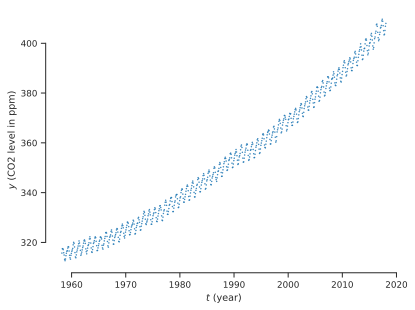

In [20]:
#load data
t = data[:, 2]  #time (in decimal dates)
y = data[:, 4]  #CO2 level (mole fraction in dry air, micromol/mol, abbreviated as ppm)
fig, ax = plt.subplots(1, 1)
ax.plot(t, y, '.', markersize=1)
ax.set_xlabel('$t$ (year)')
ax.set_ylabel('$y$ (CO2 level in ppm)')
sns.despine(trim=True);

Overall, we observe a steady growth of CO2 levels. The wiggles correspond to seasonal changes. Since most of the population inhabits the northern hemisphere, fuel consumption increases during the northern winters, and CO2 emissions follow. Our goal is to study this dataset with Gaussian process regression. Specifically, we would like to predict the evolution of the CO2 levels from Feb 2018 to Feb 2028 and quantify our uncertainty about this prediction.

Working with a scaled version of the inputs and outputs is always a good idea. We are going to scale the times as follows:

$$
t_s = t - t_{\min}.
$$

So, time is still in fractional years, but we start counting at zero instead of 1950.
We scale the $y$'s as:

$$
y_s = \frac{y - y_{\min}}{y_{\max}-y_{\min}}.
$$

This takes all the $y$ between $0$ and $1$.
Here is what the scaled data look like:

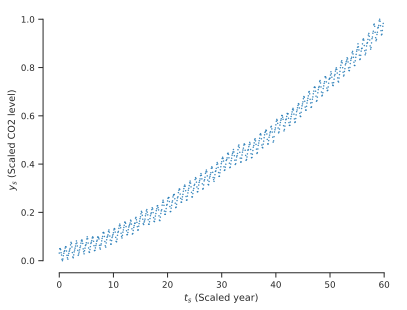

In [21]:
t_s = t - t.min()
y_s = (y - y.min()) / (y.max() - y.min())
fig, ax = plt.subplots(1, 1)
ax.plot(t_s, y_s, '.', markersize=1)
ax.set_xlabel('$t_s$ (Scaled year)')
ax.set_ylabel('$y_s$ (Scaled CO2 level)')
sns.despine(trim=True);

Work with the scaled data in what follows as you develop your model.
Scale back to the original units for your final predictions.

## Part A - Naive approach

Use a zero mean Gaussian process with a squared exponential covariance function to fit the data and make the required prediction (ten years after the last observation).

**Answer:**

**Again, this is done for you so that you have a concrete example of what is requested.**

In [22]:
cov_module = ScaleKernel(RBFKernel())
mean_module = gpytorch.means.ConstantMean()
train_x = torch.from_numpy(t_s).float()
train_y = torch.from_numpy(y_s).float()
naive_model = ExactGP(
    train_x,
    train_y,
    mean_module=mean_module,
    covar_module=cov_module
)
train(naive_model, train_x, train_y)

tensor(0.8545, grad_fn=<NegBackward0>)
tensor(0.7392, grad_fn=<NegBackward0>)
tensor(-0.5164, grad_fn=<NegBackward0>)
tensor(-1.7416, grad_fn=<NegBackward0>)
tensor(-2.1096, grad_fn=<NegBackward0>)
tensor(-2.2474, grad_fn=<NegBackward0>)
tensor(-2.0077, grad_fn=<NegBackward0>)
tensor(-2.2916, grad_fn=<NegBackward0>)
tensor(-2.3049, grad_fn=<NegBackward0>)
tensor(-2.3148, grad_fn=<NegBackward0>)
tensor(-2.3302, grad_fn=<NegBackward0>)
tensor(-2.3334, grad_fn=<NegBackward0>)
tensor(-2.2765, grad_fn=<NegBackward0>)
tensor(-2.3378, grad_fn=<NegBackward0>)
tensor(-2.3401, grad_fn=<NegBackward0>)
tensor(-2.3438, grad_fn=<NegBackward0>)
tensor(-2.3462, grad_fn=<NegBackward0>)
tensor(-2.3476, grad_fn=<NegBackward0>)
tensor(-2.3480, grad_fn=<NegBackward0>)
tensor(-2.3498, grad_fn=<NegBackward0>)
tensor(-2.3520, grad_fn=<NegBackward0>)
tensor(-2.3525, grad_fn=<NegBackward0>)
tensor(-2.3527, grad_fn=<NegBackward0>)
tensor(-2.3540, grad_fn=<NegBackward0>)
tensor(-2.3540, grad_fn=<NegBackward0>)
te

Predict everything:

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


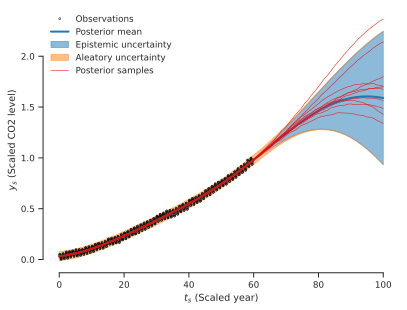

In [23]:
x_star = torch.linspace(0, 100, 100)
plot_1d_regression(model=naive_model, x_star=x_star,
                   xlabel='$t_s$ (Scaled year)', ylabel='$y_s$ (Scaled CO2 level)');

Notice that the squared exponential covariance captures the long terms but fails to capture the seasonal fluctuations. The seasonal fluctuations are treated as noise. This is wrong. You will have to fix this in the next part.

## Part B - Improving the prior covariance

Now, use the ideas of Problem 1 to develop a covariance function that exhibits the following characteristics visible in the data (call $f(x)$ the scaled CO2 level.
+ $f(x)$ is smooth.
+ $f(x)$ has a clear trend with a multi-year length scale.
+ $f(x)$ has seasonal fluctuations with a period of one year.
+ $f(x)$ exhibits small fluctuations within its period.

There is more than one correct answer.

**Answer:**
A combination of functions were used to model the seasonal fluctuations.

In [24]:
from gpytorch.kernels import PeriodicKernel
gpytorch.add_jitter.jitter_val=1e-4
cov_module = ScaleKernel(RBFKernel())# Your choice of covariance here
cov_module.outputscale = 1
cov_module.base_kernel.lengthscale = 0.1

cov_module_2 = ScaleKernel(PeriodicKernel())
cov_module_2.base_kernel.period_length = 1.0
cov_module_2.base_kernel.lengthscale = 0.1
cov_module_2.outputscale = 0.1

cov_module_3 = ScaleKernel(RBFKernel())# Your choice of covariance here
cov_module_3.base_kernel.lengthscale = 20
cov_module_3.outputscale = 0.1

cov_module = cov_module_3+cov_module*cov_module_2
mean_module = gpytorch.means.LinearMean(input_size=1)# Your choice of mean here
model = ExactGP(
    train_x,
    train_y,
    mean_module=mean_module,
    covar_module=cov_module
)
train(model, train_x, train_y)

tensor(121.1214, grad_fn=<NegBackward0>)
tensor(50.7857, grad_fn=<NegBackward0>)
tensor(18.6595, grad_fn=<NegBackward0>)
tensor(3.8353, grad_fn=<NegBackward0>)
tensor(-0.0518, grad_fn=<NegBackward0>)
tensor(-0.2300, grad_fn=<NegBackward0>)
tensor(-0.2448, grad_fn=<NegBackward0>)
tensor(-0.3097, grad_fn=<NegBackward0>)
tensor(-0.7821, grad_fn=<NegBackward0>)
tensor(-1.6252, grad_fn=<NegBackward0>)
tensor(-2.2937, grad_fn=<NegBackward0>)
tensor(-2.4403, grad_fn=<NegBackward0>)
tensor(-2.4452, grad_fn=<NegBackward0>)
tensor(-2.4476, grad_fn=<NegBackward0>)
tensor(-2.4587, grad_fn=<NegBackward0>)
tensor(-2.4837, grad_fn=<NegBackward0>)
tensor(-2.5594, grad_fn=<NegBackward0>)
tensor(-2.6768, grad_fn=<NegBackward0>)
tensor(-2.7682, grad_fn=<NegBackward0>)
tensor(-2.9221, grad_fn=<NegBackward0>)
tensor(-2.9574, grad_fn=<NegBackward0>)
tensor(-2.9598, grad_fn=<NegBackward0>)
tensor(-2.9606, grad_fn=<NegBackward0>)
Iter   1/10 - Loss: 121.121
tensor(-2.9606, grad_fn=<NegBackward0>)
tensor(-2.96

Plot using the following block:

/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


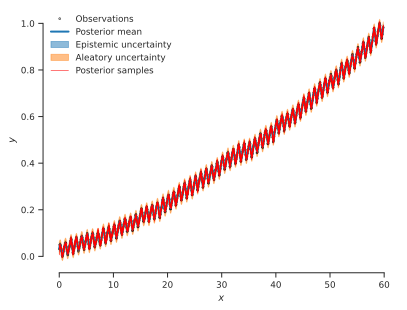

In [25]:
plot_1d_regression(model=model, x_star=train_x);

## Part C - Predicting the future

How does your model predict the future? Why is it better than the naive model?

**Answer:**
My model predicts the future as it has been trained on historical data and can now take new inputs of future years to predict.
It is better than the naive model because my model accomodates the seasonal variation in the CO2 levels which the naive model does not capture.

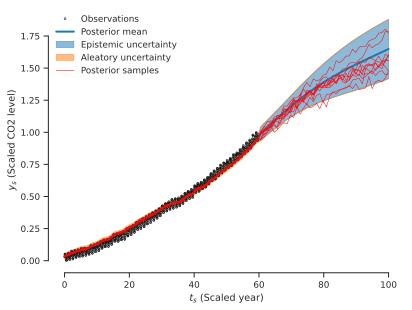

In [26]:
x_star = torch.linspace(0, 100, 100)
plot_1d_regression(model=model, x_star=x_star,
                   xlabel='$t_s$ (Scaled year)', ylabel='$y_s$ (Scaled CO2 level)');

In [28]:
def plot_1d_regression_scaled(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10,
    xlabel='$x$',
    ylabel='$y$'
):
    """Plot the posterior predictive.

    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.

    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    xlabel      --  The x-axis label.
    ylabel      --  The y-axis label.
    """
    f_star = model(x_star)
    m_star = f_star.mean*(y.max()-y.min())+y.min()
    v_star = f_star.variance
    y_star = model.likelihood(f_star)*(y.max()-y.min())+y.min()
    yv_star = y_star.variance

    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )

    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(model.train_inputs[0].flatten().detach()+1958,
            model.train_targets.detach()*(y.max()-y.min())+y.min(),
            'k.',
            markersize=1,
            markeredgewidth=2,
            label='Observations'
    )

    ax.plot(
        x_star+1958,
        m_star.detach(),
        lw=2,
        label='Posterior mean',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.flatten().detach()+1958,
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label='Epistemic uncertainty',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.detach().flatten()+1958,
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label='Aleatory uncertainty'
    )
    ax.fill_between(
        x_star.detach().flatten()+1958,
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None
    )


    if f_true is not None:
        ax.plot(
            x_star+1958,
            f_true(x_star),
            'm-.',
            label='True function'
        )

    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([10])
        )
        ax.plot(
            x_star.numpy()+1958,
            f_post_samples.T.detach().numpy()*(y.max()-y.min())+y.min(),
            color="red",
            lw=0.5
        )
        # This is just to add the legend entry
        ax.plot(
            [],
            [],
            color="red",
            lw=0.5,
            label="Posterior samples"
        )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True)

    return dict(m_star=m_star, v_star=v_star, ax=ax)

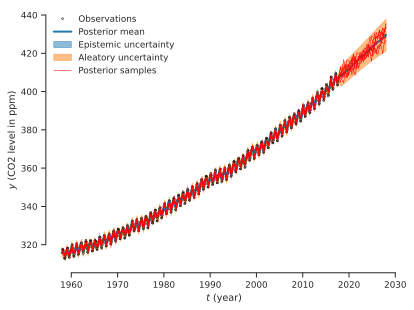

In [29]:
x_star = torch.linspace(0, 70, 200)
plot_1d_regression_scaled(model=model, x_star=x_star,
                   xlabel='$t$ (year)', ylabel='$y$ (CO2 level in ppm)');

## Part D - Bayesian information criterion

As we have seen in earlier lectures, the Bayesian informationc criterion (BIC), see [this](https://en.wikipedia.org/wiki/Bayesian_information_criterion), can bse used to compare two models.
The criterion says that one should:
+ fit the models with maximum likelihood,
+ and compute the quantity:

$$
\text{BIC} = d\ln(n) - 2\ln(\hat{L}),
$$

where $d$ is the number of model parameters, and $\hat{L}$ the maximum likelihood.
+ pick the model with the smallest BIC.

Use BIC to show that the model you constructed in Part C is indeed better than the naïve model of Part A.

**Answer:**
The BIC for my model is higher than the naive model and it also uses more parameters(10) than the naive model(4). BIC in this case is not a good criteria for comparing these two models.

In [30]:
# Hint: You can find the parameters of a model like this
list(naive_model.hyperparameters())

[Parameter containing:
 tensor([-28.6225], requires_grad=True),
 Parameter containing:
 tensor(0.8225, requires_grad=True),
 Parameter containing:
 tensor(-0.3027, requires_grad=True),
 Parameter containing:
 tensor([[34.8740]], requires_grad=True)]

In [31]:
m = sum(p.numel() for p in naive_model.hyperparameters())
print(m)

4


In [32]:
# Hint: You can find the (marginal) log likelihood of a model like this
mll = gpytorch.mlls.ExactMarginalLogLikelihood(naive_model.likelihood, naive_model)
log_like = mll(naive_model(train_x), train_y)
print(log_like)

tensor(1.2229, grad_fn=<DivBackward0>)


In [33]:
# Hint: The BIC is
bic = -2 * log_like + m * np.log(train_x.shape[0])
print(f"BIC of Naive Model: {bic}")

BIC of Naive Model: 23.865619659423828


In [34]:
# Your code here
m_1 = sum(p.numel() for p in model.hyperparameters())
print(m_1)
mll_1 = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
log_like_1 = mll_1(model(train_x), train_y)
# print(log_like_1)
bic_1 = -2 * log_like_1 + m_1 * np.log(train_x.shape[0])
print(print(f"BIC of Improved Model: {bic_1}"))

10
BIC of Improved Model: 58.730567932128906
None
